In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from pprint import pprint
import itertools

import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import os
from lightgbm import LGBMClassifier
import seaborn as sns
from typing import List, Any
from matplotlib import pyplot as plt

pd.set_option("max_colwidth", 80)
RANDOM_SEED = 42  # For reproducibility

In [3]:
PROJECT_DIR = os.path.abspath('.')
if PROJECT_DIR.endswith('final-nbs'):
    PROJECT_DIR = os.path.abspath('../')
    os.chdir(PROJECT_DIR)

In [4]:
import cfg
from src.data import get_features_path_from_metadata, join_dataframe_columns
from src import util
from src.data import setup_directories

util.setup_logging()

dirs = setup_directories(cfg.DATA_DIR, create_dirs=True)

In [5]:
raw_dir = Path(dirs['raw'])

In [6]:
# read metadata
pd_metadata = pd.read_csv(raw_dir / "metadata.csv", index_col="sample_id")
pd_metadata.head()

,split,instrument_type,features_path,features_md5_hash
sample_id,,,,
S0000,train,commercial,train_features/S0000.csv,017b9a71a702e81a828e6242aa15f049
S0001,train,commercial,train_features/S0001.csv,0d09840214054d254bd49436c6a6f315
S0002,train,commercial,train_features/S0002.csv,3f58b3c9b001bfed6ed4e4f757083e09
S0003,train,commercial,train_features/S0003.csv,e9a12f96114a2fda60b36f4c0f513fb1
S0004,train,commercial,train_features/S0004.csv,b67603d3931897bfa796ac42cc16de78


In [7]:
train_files = get_features_path_from_metadata(pd_metadata.query("split == 'train'"), raw_dir)

In [8]:
from sklearn.preprocessing import scale
temp_bins = pd.interval_range(-100, 1600, freq=10)
def compute_temp_abun_agg(sample_data: pd.DataFrame):
    sample_data['temp_bin'] = pd.cut(sample_data['temp'], temp_bins).apply(lambda x: (x.left + x.right) // 2).astype(np.int64)
    sample_data['abundance_scaled'] = sample_data.groupby(['m/z'])['abundance'].transform(scale)
    agg_temp_abun = sample_data.groupby(['m/z', 'temp_bin'])['abundance_scaled'].mean().reset_index()
    
#     agg_temp_abun.pivot('m/z', 'temp_bin', 'abundance_scaled')
    
    return agg_temp_abun

In [9]:
from src.preprocessing import apply_preprocessing_fn

In [10]:
_raw_features = apply_preprocessing_fn(train_files, pd_metadata, processing_fn=compute_temp_abun_agg)

raw_features = (
    pd.concat(_raw_features,  names=['sample_id', 'dummy_index'])
    .reset_index(level='dummy_index', drop=True)
)

  0%|          | 0/766 [00:00<?, ?it/s]

In [11]:
pd_features_with_nan = raw_features.reset_index().pivot(['sample_id', 'm/z'], 'temp_bin', 'abundance_scaled')

In [12]:
pd_features_with_nan.head()

temp_bin       -65    -55    -45    -35    -25    -15    -5      5      15    \
sample_id m/z                                                                  
S0000     0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          1      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          2      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          5      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

temp_bin        25    ...   1395   1405   1415   1425   1435   1445   1455  \
sample_id m/z         ...                                                    
S0000     0      NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          1      NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          2      NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          3      NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          5      NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

temp_bin        1465   1475   1485  
sample_id m/z                       
S0000     0      NaN    NaN    NaN  
          1      NaN    NaN    NaN  
          2      NaN    NaN    NaN  
          3      NaN    NaN    NaN  
          5      NaN    NaN    NaN  

[5 rows x 156 columns]

In [13]:
# to solve nan, just back fill and forward fill

In [14]:
pd_features = pd_features_with_nan.T.fillna(method='bfill').fillna(method='ffill').T

<AxesSubplot:xlabel='temp_bin'>

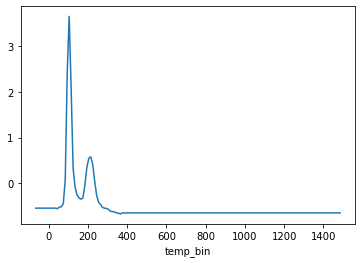

In [15]:
pd_features.iloc[0].plot()

<AxesSubplot:xlabel='temp_bin'>

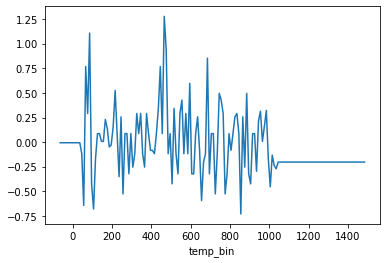

In [16]:
pd_features.iloc[-1].plot()

In [17]:
# seems ok again

In [18]:
# design model and dataset

In [19]:
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import torch
import numpy as np
import pandas as pd
import collections
from torch import nn, optim
from torch.nn import functional as F
from collections import OrderedDict


class AEDataset(Dataset):
    def __init__(self, features: np.ndarray):
        self.features = features.astype(np.float32)
    
    
    def __len__(self):
        return len(self.features)
    
    
    def __getitem__(self, idx: int) -> torch.tensor:
        return torch.from_numpy(self.features[idx])

In [20]:
from sklearn.model_selection import train_test_split
pd_train_features, pd_test_features = train_test_split(pd_features, test_size=0.2)

In [21]:
train_features = pd_train_features.to_numpy()

In [22]:
train_ds = AEDataset(train_features)
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True)
not_shuffle_train_dl = DataLoader(train_ds, batch_size=512, shuffle=False)

In [23]:
test_features = pd_test_features.to_numpy()

test_ds = AEDataset(test_features)
test_dl = DataLoader(test_ds, batch_size=512, shuffle=False)

In [24]:
window_dim = len(pd_test_features.columns)

In [25]:
label_sm = 0.001
from typing import Callable, List
def train_model(
    model: torch.nn.Module,
    optimizer: optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    epochs: int,
    criterion: Callable,
) -> int:
    """Train routine for the autoencoder.
    Parameters
    ----------
    model: torch.nn.Module
        Neural network model used in this example.
    train_loader: torch.utils.data.DataLoader
        DataLoader used in training.
    epochs: int
        Number of epochs to run in each round.
    device: torch.device
         (Default value = torch.device("cpu"))
         Device where the network will be trained within a client.
    pos_weight: float
        (Default value = None)
        a weight of positive examples.
    Returns
    -------
    num_examples_train: int
        Number of total samples used during training.
    """
    model.train()
    print(f"Training {epochs} epoch(s) w/ {len(train_loader)} mini-batches each")
    for epoch in range(epochs):  # loop over the dataset multiple times
        loss_epoch: float = 0.0
        num_examples_train: int = 0
        for batch_idx, x in enumerate(train_loader):
            num_examples_train += len(x)
            optimizer.zero_grad()
        
            yhat = model(x)
            loss = criterion(yhat, x)
            loss.backward()
            optimizer.step()

            loss_epoch += loss.item()
            print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}\t\t\t\t".format(
                        epoch,
                        num_examples_train,
                        len(train_loader) * train_loader.batch_size,
                        100.0 * num_examples_train / len(train_loader) / train_loader.batch_size,
                        loss.item(),
                    ),
                    end="\r",
                    flush=True,
                )
        
def predict_dl(model: nn.Module, valid_dl: DataLoader):
    model.eval()
    with torch.no_grad():
        
        prediction = torch.cat([model(x)
                               for x in valid_dl])
    return prediction.numpy().astype(np.float64)

In [26]:
class AEModel(nn.Module):
    def __init__(self, window_dim: int, kernel_size: int = 5,
                 hidden_dim: int = 16, encoded_dim: int = 8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, hidden_dim//2, kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(hidden_dim//2, hidden_dim, kernel_size=kernel_size),
            nn.AdaptiveAvgPool1d(encoded_dim),
        )
        self.decoder = nn.Linear(hidden_dim * encoded_dim, window_dim)
    
    def _encode(self, x):
        bs, ft = x.size()
        x = x.view(bs, -1, ft)
        return self.encoder(x).view(bs, -1)
    
    def forward(self, x):
        bs = len(x)
        encoded = self._encode(x)
        return self.decoder(encoded)
    
    def encode(self, x: np.ndarray):
        self.eval()
        ds = AEDataset(x)
        dl = DataLoader(ds, batch_size=512)
        with torch.no_grad():
            encoded = torch.cat([
                self._encode(batch_x) for batch_x in dl
            ], dim=0)
        
        return encoded.numpy()
        

In [27]:
model = AEModel(window_dim, encoded_dim=5, hidden_dim=5)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [28]:
model

AEModel(
  (encoder): Sequential(
    (0): Conv1d(1, 2, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(2, 5, kernel_size=(5,), stride=(1,))
    (4): AdaptiveAvgPool1d(output_size=5)
  )
  (decoder): Linear(in_features=25, out_features=156, bias=True)
)

In [29]:
sum([p.numel() for p in model.parameters()])

4123

In [30]:
train_model(model, optimizer, train_dl, 30, criterion, )

Training 30 epoch(s) w/ 115 mini-batches each


In [31]:
test_yhat = predict_dl(model, test_dl)
train_yhat = predict_dl(model, not_shuffle_train_dl)

In [32]:
def rmse(y, yhat):
    return np.sqrt(np.square(y - yhat).mean())

train_error = rmse(train_features, train_yhat)
test_error = rmse(test_features, test_yhat)

In [33]:
train_error, test_error # both are pretty close, so no overfitting!

(0.3800934344256993, 0.37917074816997903)

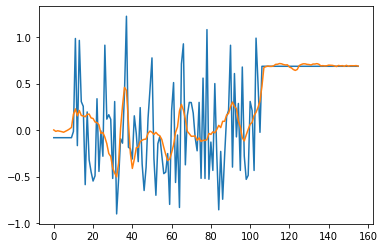

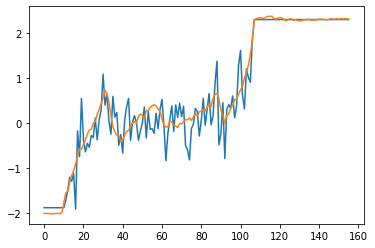

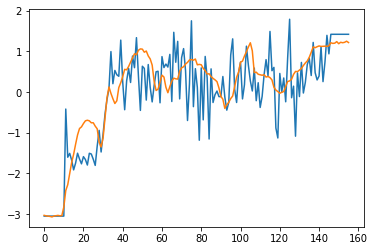

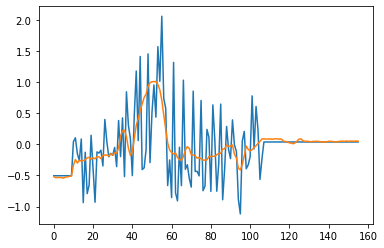

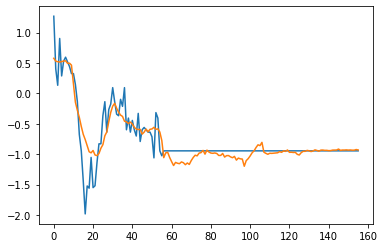

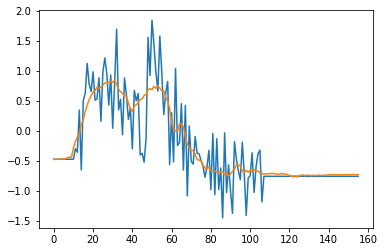

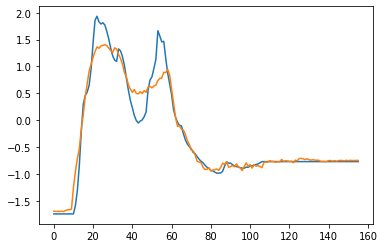

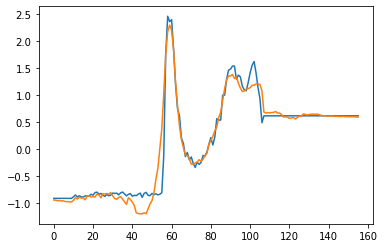

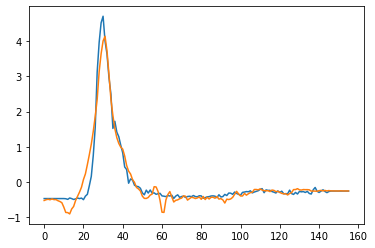

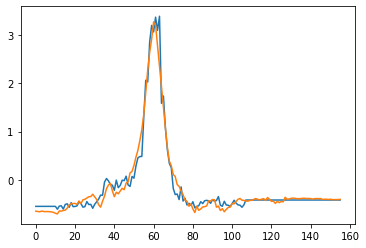

In [34]:
random_idx = np.random.choice(len(test_yhat), size=10)
for idx in random_idx:
    plt.figure()
    plt.plot(test_features[idx])
    plt.plot(test_yhat[idx])


In [35]:
encoded_features = model.encode(pd_features.to_numpy())

In [36]:
# lets do kmeans now

In [37]:
from sklearn.cluster import KMeans

In [38]:
n_clusters = 12
kmeans = KMeans(n_clusters).fit(encoded_features)
ae_clusters = kmeans.predict(encoded_features)

In [39]:
pd_ae_clusters = pd.Series(ae_clusters, name='cluster', index=pd_features.index)

In [40]:
pd_ae_clusters.value_counts(normalize=True).sort_index()

0     0.104894
1     0.037798
2     0.002856
3     0.078126
4     0.049876
5     0.011126
6     0.131158
7     0.259093
8     0.120359
9     0.069625
10    0.070469
11    0.064620
Name: cluster, dtype: float64

In [41]:
centroids = kmeans.cluster_centers_

In [42]:
torch_centroids = torch.from_numpy(centroids.astype(np.float32))

In [43]:
with torch.no_grad():
    signal_centroids = model.decoder(torch_centroids).numpy()

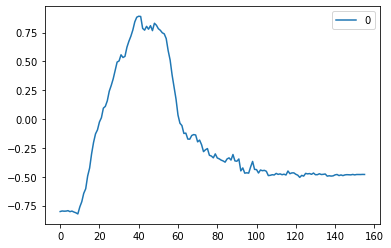

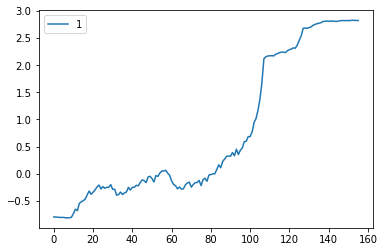

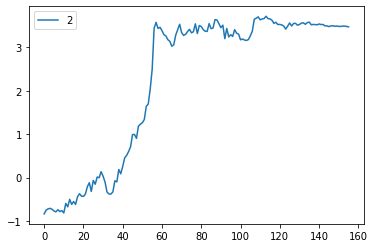

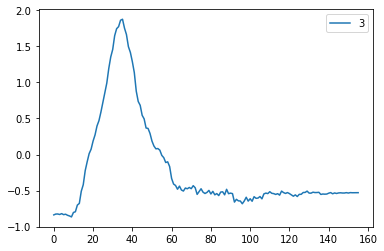

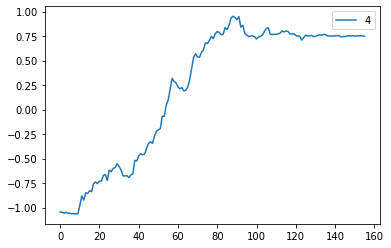

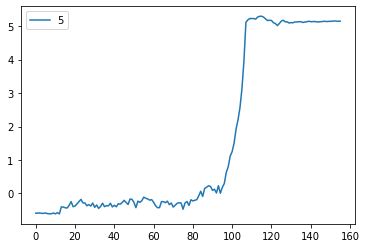

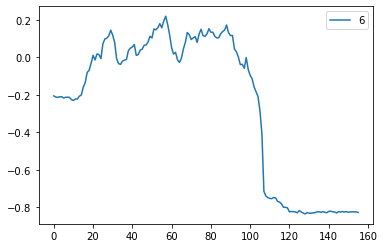

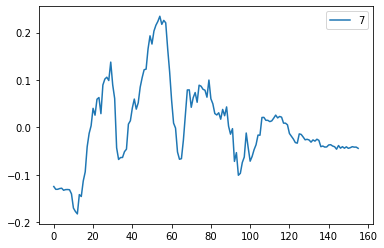

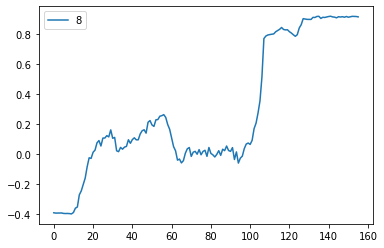

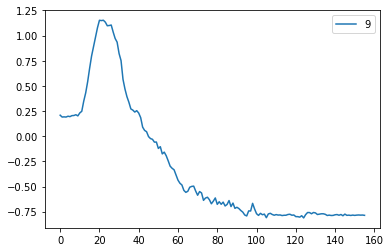

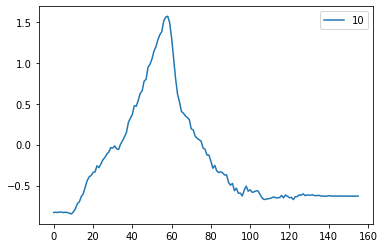

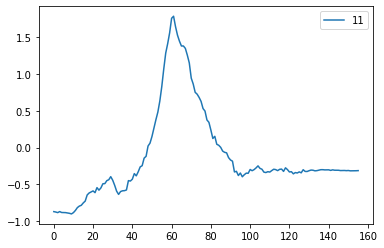

In [44]:
for i, signal in enumerate(signal_centroids):
    plt.figure()
    plt.plot(signal, label=i)
    plt.legend()

In [45]:
pd_encoded_features = pd.DataFrame(encoded_features, index=pd_features.index)

In [46]:
pd_encoded_features

0         1         2         3         4         5   \
sample_id m/z                                                               
S0000     0    0.001975 -0.098146  0.029971  0.029971  0.029971  0.321787   
          1    0.017735 -0.110391  0.033576  0.033576  0.033576  0.352047   
          2    0.012341 -0.109165  0.030429  0.030429  0.030429  0.361194   
          3   -0.377189  0.042650  0.807674  0.807674  0.807674 -0.219822   
          5    0.068650 -0.116189  0.035308  0.035308  0.035308  0.400098   
...                 ...       ...       ...       ...       ...       ...   
S0765     95  -0.062616  0.009054  0.032028 -0.133010 -0.017367  0.301014   
          96  -0.306701 -0.025455 -0.064212 -0.109568  0.020979 -0.134998   
          97  -0.619630 -0.027119 -0.091137  0.029783 -0.011394 -0.600670   
          98  -0.472011 -0.003818  0.057374 -0.044808 -0.008735 -0.274848   
          99  -0.013263 -0.026599 -0.051542 -0.118506 -0.013311  0.345521   

                     6         7         8         9   ...        15  \
sample_id m/z                                          ...             
S0000     0    0.255254  0.384008  0.384008  0.384008  ... -0.369298   
          1    0.234073  0.385959  0.385959  0.385959  ... -0.384027   
          2    0.233486  0.384256  0.384256  0.384256  ... -0.425610   
          3   -0.714096 -0.187930 -0.187930 -0.187930  ... -0.336183   
          5    0.187731  0.386896  0.386896  0.386896  ... -0.366301   
...                 ...       ...       ...       ...  ...       ...   
S0765     95   0.283158  0.452577  0.125412  0.358392  ... -0.190337   
          96   0.321956  0.235643  0.150268  0.379142  ... -0.208336   
          97   0.270568  0.354774  0.343003  0.361625  ... -0.417835   
          98   0.342565  0.509920  0.226345  0.363064  ... -0.225623   
          99   0.402883  0.292016  0.205570  0.360587  ... -0.167029   

                     16        17        18        19        20        21  \
sample_id m/z                                                               
S0000     0    0.615134  0.486541  0.486541  0.486541  0.416813  0.156472   
          1    0.652833  0.520207  0.520207  0.520207  0.368658  0.179022   
          2    0.677128  0.490822  0.490822  0.490822  0.375537  0.171922   
          3    1.301736  0.968091  0.968091  0.968091  1.452329  0.792365   
          5    0.659621  0.536377  0.536377  0.536377  0.313139  0.242067   
...                 ...       ...       ...       ...       ...       ...   
S0765     95  -0.158415 -0.283025  0.006954  0.044539  0.431152  0.499916   
          96  -0.362740 -0.023972  0.321456  0.402583  1.271563  0.413225   
          97   0.040049  0.103875  0.082523  0.100317  2.222973  0.356753   
          98   0.005345 -0.097318  0.012885  0.125141  1.542715  0.327063   
          99  -0.348759 -0.226948  0.024713  0.082417  0.337840  0.253104   

                     22        23        24  
sample_id m/z                                
S0000     0   -0.022141 -0.022141 -0.022141  
          1   -0.040986 -0.040986 -0.040986  
          2   -0.024537 -0.024537 -0.024537  
          3   -0.561336 -0.561336 -0.561336  
          5   -0.050036 -0.050036 -0.050036  
...                 ...       ...       ...  
S0765     95   0.213897  0.672358  0.225266  
          96   0.445524  0.481912  0.024853  
          97   0.131099  0.230695  0.194045  
          98   0.008293  0.529427  0.180150  
          99   0.446565  0.492751  0.204065  

[73522 rows x 25 columns]

<AxesSubplot:>

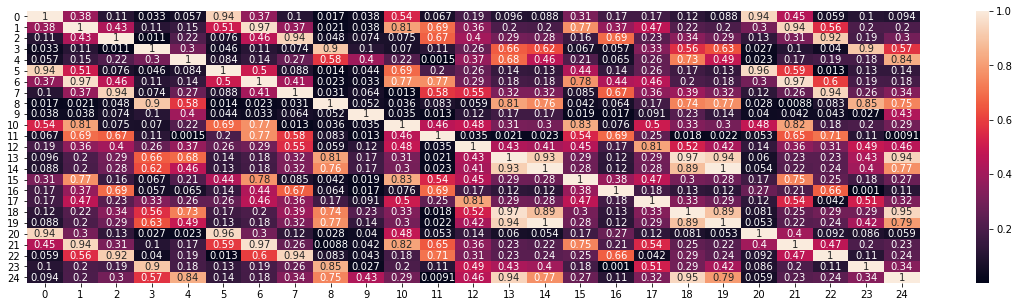

In [47]:
plt.figure(figsize=(20, 5))
sns.heatmap(pd_encoded_features.corr().abs(), annot=True)

In [48]:
test_files = get_features_path_from_metadata(pd_metadata.query("split != 'train'"), raw_dir)

In [49]:
_raw_test_features = apply_preprocessing_fn(test_files, pd_metadata, processing_fn=compute_temp_abun_agg)

raw_test_features = (
    pd.concat(_raw_test_features,  names=['sample_id', 'dummy_index'])
    .reset_index(level='dummy_index', drop=True)
)

  0%|          | 0/804 [00:00<?, ?it/s]

In [50]:
pd_test_features_with_nan = raw_test_features.reset_index().pivot(['sample_id', 'm/z'], 'temp_bin', 'abundance_scaled')

In [51]:
pd_test_features_with_nan.head()

temp_bin       -65    -55    -45    -35    -25    -15    -5      5      15    \
sample_id m/z                                                                  
S0766     0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          1      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          2      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          5      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

temp_bin           25    ...   1395   1405   1415   1425   1435   1445   1455  \
sample_id m/z            ...                                                    
S0766     0   -1.801588  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          1   -1.877517  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          2   -1.765920  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          3   -0.667752  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
          5   -0.673529  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

temp_bin        1465   1475   1485  
sample_id m/z                       
S0766     0      NaN    NaN    NaN  
          1      NaN    NaN    NaN  
          2      NaN    NaN    NaN  
          3      NaN    NaN    NaN  
          5      NaN    NaN    NaN  

[5 rows x 156 columns]

In [52]:
# to solve nan, just back fill and forward fill

pd_test_features = pd_test_features_with_nan.T.fillna(method='bfill').fillna(method='ffill').T

<AxesSubplot:xlabel='temp_bin'>

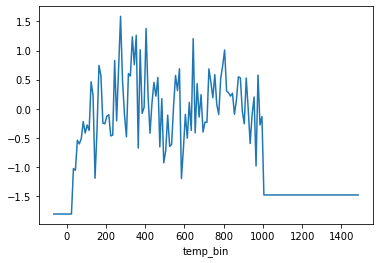

In [53]:
pd_test_features.iloc[0].plot()

<AxesSubplot:xlabel='temp_bin'>

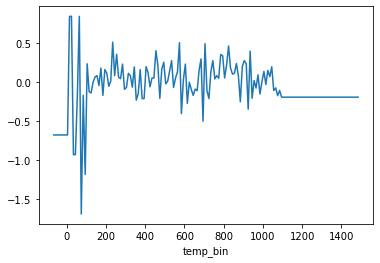

In [54]:
pd_test_features.iloc[-1].plot()

In [55]:
test_encoded_features = model.encode(pd_test_features.to_numpy())

In [56]:
test_ae_clusters = kmeans.predict(test_encoded_features)
pd_test_ae_clusters = pd.Series(test_ae_clusters, name='cluster', index=pd_test_features.index)

In [57]:
valid_index = pd_metadata.index[pd_metadata['split'] == 'val']

In [58]:
train_dir = Path(dirs['train'])
valid_dir = Path(dirs['valid'])
test_dir = Path(dirs['test'])

In [59]:
pd_ae_clusters_features = (
    pd_ae_clusters
    .to_frame()
    .reset_index()
    .pivot('sample_id', 'm/z', 'cluster')
).add_prefix('cluster_mz').fillna(-1)

In [60]:
pd_test_ae_clusters_features = (
    pd_test_ae_clusters
    .to_frame()
    .reset_index()
    .pivot('sample_id', 'm/z', 'cluster')
).add_prefix('cluster_mz').fillna(-1)

In [61]:
pd_ae_clusters_features.head()

m/z,cluster_mz0,cluster_mz1,cluster_mz2,cluster_mz3,cluster_mz5,cluster_mz6,cluster_mz7,cluster_mz8,cluster_mz9,cluster_mz10,...,cluster_mz90,cluster_mz91,cluster_mz92,cluster_mz93,cluster_mz94,cluster_mz95,cluster_mz96,cluster_mz97,cluster_mz98,cluster_mz99
sample_id,,,,,,,,,,,,,,,,,,,,,
S0000,9.0,9.0,9.0,9.0,9.0,7.0,7.0,7.0,7.0,7.0,...,9.0,7.0,4.0,9.0,9.0,9.0,9.0,7.0,7.0,9.0
S0001,-1.0,4.0,7.0,9.0,4.0,7.0,7.0,4.0,9.0,9.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
S0002,9.0,9.0,9.0,9.0,9.0,7.0,6.0,6.0,6.0,7.0,...,6.0,7.0,6.0,7.0,6.0,6.0,7.0,8.0,8.0,1.0
S0003,9.0,9.0,3.0,9.0,9.0,6.0,7.0,10.0,6.0,11.0,...,6.0,6.0,8.0,6.0,0.0,7.0,8.0,7.0,7.0,8.0
S0004,9.0,9.0,9.0,9.0,9.0,9.0,9.0,6.0,9.0,0.0,...,7.0,7.0,7.0,6.0,7.0,7.0,6.0,8.0,6.0,8.0


In [62]:
pd_test_ae_clusters_features.head()

m/z,cluster_mz0,cluster_mz1,cluster_mz2,cluster_mz3,cluster_mz5,cluster_mz6,cluster_mz7,cluster_mz8,cluster_mz9,cluster_mz10,...,cluster_mz90,cluster_mz91,cluster_mz92,cluster_mz93,cluster_mz94,cluster_mz95,cluster_mz96,cluster_mz97,cluster_mz98,cluster_mz99
sample_id,,,,,,,,,,,,,,,,,,,,,
S0766,0.0,6.0,8.0,1.0,8.0,8.0,1.0,7.0,7.0,6.0,...,6.0,6.0,7.0,7.0,6.0,8.0,7.0,7.0,6.0,8.0
S0767,8.0,8.0,4.0,4.0,7.0,7.0,7.0,8.0,6.0,8.0,...,7.0,7.0,8.0,7.0,8.0,8.0,7.0,7.0,7.0,7.0
S0768,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,8.0,7.0,0.0,7.0,7.0,8.0,6.0,7.0,6.0
S0769,11.0,10.0,4.0,4.0,4.0,8.0,7.0,7.0,7.0,8.0,...,11.0,10.0,7.0,11.0,4.0,7.0,8.0,10.0,7.0,6.0
S0770,9.0,9.0,9.0,9.0,9.0,10.0,6.0,9.0,0.0,6.0,...,8.0,0.0,9.0,7.0,7.0,8.0,6.0,6.0,7.0,8.0


In [63]:
pd_valid_ae_clusters_features = pd_test_ae_clusters_features.loc[valid_index]

In [64]:
pd_encoded_features.to_csv(train_dir / 'ae_embedding.csv', index=True)
pd_ae_clusters_features.to_csv(train_dir / 'ae_clusters.csv', index=True)

In [65]:
# pd_valid_encoded_features.to_csv(valid_dir / 'ae_embedding.csv', index=True)
pd_valid_ae_clusters_features.to_csv(valid_dir / 'ae_clusters.csv', index=True)

In [66]:
# pd_test_encoded_features.to_csv(test_dir / 'ae_embedding.csv', index=True)
pd_test_ae_clusters_features.to_csv(test_dir / 'ae_clusters.csv', index=True)

In [67]:
# do need all that information???

In [68]:
onehot_ae_clusters = pd.get_dummies(pd_ae_clusters_features, columns=pd_ae_clusters_features.columns)

In [69]:
corr_matrix = onehot_ae_clusters.corr()

In [70]:
def get_upper_traingle(data: pd.DataFrame):
    shape = data.shape
    upper_tri = np.triu(np.ones(shape, dtype=np.bool_), k=1)
    return data.where(upper_tri)

In [71]:
utriu_corr = get_upper_traingle(corr_matrix)

In [72]:
utriu_corr.head()

,cluster_mz0_-1.0,cluster_mz0_0.0,cluster_mz0_1.0,cluster_mz0_3.0,cluster_mz0_4.0,cluster_mz0_6.0,cluster_mz0_7.0,cluster_mz0_8.0,cluster_mz0_9.0,cluster_mz0_10.0,...,cluster_mz99_0.0,cluster_mz99_1.0,cluster_mz99_3.0,cluster_mz99_4.0,cluster_mz99_6.0,cluster_mz99_7.0,cluster_mz99_8.0,cluster_mz99_9.0,cluster_mz99_10.0,cluster_mz99_11.0
cluster_mz0_-1.0,NaN,-0.140214,-0.035022,-0.132536,-0.065627,-0.091157,-0.076968,-0.061478,-0.147142,-0.105433,...,-0.044476,-0.038415,-0.022062,-0.029243,-0.132545,-0.199815,-0.144004,-0.016311,-0.019094,-0.019094
cluster_mz0_0.0,NaN,NaN,-0.052958,-0.200415,-0.099238,-0.137844,-0.116388,-0.092964,-0.222501,-0.159431,...,-0.019198,-0.030418,0.014316,0.100226,0.002963,0.003088,0.048984,0.041993,-0.028873,0.026144
cluster_mz0_1.0,NaN,NaN,NaN,-0.050058,-0.024787,-0.034430,-0.029070,-0.023220,-0.055575,-0.039822,...,0.063624,-0.014509,-0.008333,-0.011045,0.034403,-0.018811,0.005128,-0.017841,-0.007212,-0.007212
cluster_mz0_3.0,NaN,NaN,NaN,NaN,-0.093804,-0.130296,-0.110014,-0.087874,-0.210317,-0.150701,...,0.036215,0.002550,0.017964,-0.004307,0.032617,0.015920,0.024946,-0.043967,-0.027292,0.029827
cluster_mz0_4.0,NaN,NaN,NaN,NaN,NaN,-0.064517,-0.054475,-0.043512,-0.104141,-0.074621,...,0.012846,-0.027189,-0.015615,0.112530,-0.004228,0.071313,-0.052716,-0.033433,-0.013514,-0.013514


In [73]:
high_correlated_features = [f for f in utriu_corr if utriu_corr[f].abs().max() >= 0.95]

In [74]:
len(high_correlated_features) # very correlated features, but what to drop???

105

In [75]:
# there must be another way

In [76]:
from collections import Counter
cluster_count = [
    Counter(sample.astype(np.int64))
     for sample in pd_ae_clusters_features.to_numpy()
]
cluster_count = pd.DataFrame(cluster_count, index=pd_ae_clusters_features.index)

In [77]:
n_different_clusters = cluster_count.notna().sum(axis=1)

/home/med/anaconda3/envs/mars/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


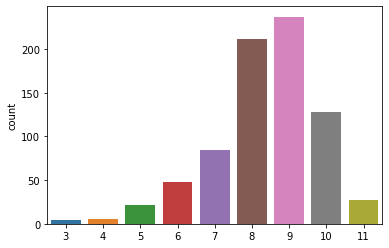

In [78]:
sns.countplot(n_different_clusters);

In [79]:
cluster_count

,9,7,0,8,4,-1,2,6,10,11,1,3,5
sample_id,,,,,,,,,,,,,
S0000,45.0,30.0,5.0,8.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0001,24.0,9.0,NaN,2.0,5.0,40.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
S0002,12.0,10.0,9.0,10.0,2.0,NaN,NaN,25.0,8.0,21.0,2.0,NaN,NaN
S0003,9.0,13.0,6.0,14.0,3.0,NaN,NaN,18.0,1.0,27.0,6.0,2.0,NaN
S0004,13.0,12.0,33.0,3.0,2.0,NaN,NaN,8.0,2.0,5.0,1.0,20.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S0761,54.0,20.0,NaN,4.0,2.0,8.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN
S0762,1.0,17.0,2.0,1.0,25.0,11.0,NaN,10.0,12.0,20.0,NaN,NaN,NaN
S0763,28.0,26.0,NaN,NaN,1.0,10.0,NaN,34.0,NaN,NaN,NaN,NaN,NaN


In [80]:
# ok, most of the samples has up to 9 different clusters, difficult to reduce memory :(((((

In [81]:
# maybe there is a pattern, lets see

In [82]:
pd_train_target = pd.read_csv(raw_dir / 'train_labels.csv', index_col='sample_id')

In [83]:
pd_train_target = pd_train_target.join(n_different_clusters.to_frame('n_clusters'))

In [84]:
pd_train_target['n_targets'] = np.minimum(pd_train_target[cfg.TARGETS].sum(axis=1), 2)

In [85]:
(
    pd_train_target[['n_targets', 'n_clusters']]
    .value_counts()
    .to_frame('count')
    .reset_index()
    .pivot('n_targets', 'n_clusters', 'count')
)

n_clusters,3,4,5,6,7,8,9,10,11
n_targets,,,,,,,,,
0,NaN,1.0,4.0,7.0,11.0,20.0,33.0,18.0,8.0
1,3.0,4.0,14.0,31.0,44.0,123.0,122.0,63.0,14.0
2,1.0,NaN,3.0,10.0,29.0,69.0,82.0,47.0,5.0


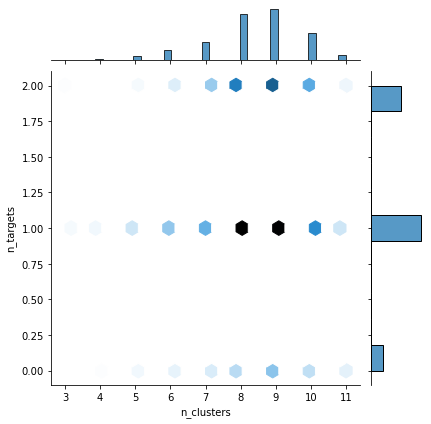

In [86]:
sns.jointplot(x='n_clusters', y='n_targets', data=pd_train_target, kind='hex')

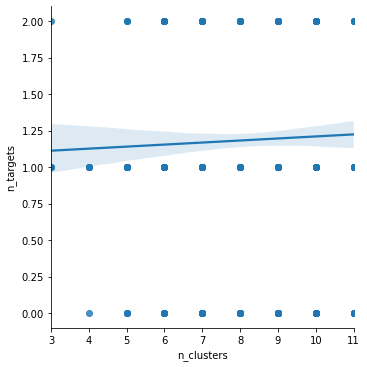

In [87]:
sns.lmplot(x='n_clusters', y='n_targets', data=pd_train_target)